## Importing libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, \
    Bidirectional, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import itertools
import matplotlib.pyplot as plt

## importing data

In [4]:
mit_test = pd.read_csv('./data/mitbih_test.csv', header=None)
mit_train = pd.read_csv('./data/mitbih_train.csv', header=None)
mit_test.rename(columns={187: "Class"}, inplace=True)
mit_train.rename(columns={187: "Class"}, inplace=True)
print("MIT Train classes: \n", mit_train["Class"].value_counts())
print("\nMIT Test classes: \n", mit_test["Class"].value_counts())
print(mit_train.shape)
print(mit_test.shape)
MIT_Outcome = {0.: 'N',
               1.: 'S',
               2.: 'V',
               3.: 'F',
               4.: 'Q'}

MIT Train classes: 
 Class
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

MIT Test classes: 
 Class
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64
(87554, 188)
(21892, 188)


#### Setting Dictionary to define the type of Heartbeat
##### N: normal
##### S: Supraventricular premature beat
##### P: Premature ventricular contraction
##### F: Fusion of ventricular and normal beat
##### U: Unclassifiable beat

In [5]:
train_mit, valid_mit = train_test_split(mit_train, test_size=0.20, random_state=42)
class_0 = train_mit[train_mit["Class"] == 0]
class_1 = train_mit[train_mit["Class"] == 1]
class_2 = train_mit[train_mit["Class"] == 2]
class_3 = train_mit[train_mit["Class"] == 3]
class_4 = train_mit[train_mit["Class"] == 4]

### upsampling and equalize the number of sample for each class


In [6]:
class_0_upsample = class_0
class_1_upsample = resample(class_1, replace=True, n_samples=10000, random_state=123)
class_2_upsample = resample(class_2, replace=True, n_samples=10000, random_state=124)
class_3_upsample = resample(class_3, replace=True, n_samples=10000, random_state=125)
class_4_upsample = resample(class_4, replace=True, n_samples=10000, random_state=126)

### combine


In [7]:
mit_train = pd.concat([class_0_upsample, class_1_upsample, class_2_upsample, class_3_upsample, class_4_upsample])
train_mit, out_train_mit = mit_train.iloc[:, :187], mit_train.iloc[:, -1]
valid_mit, out_valid_mit = valid_mit.iloc[:, :187], valid_mit.iloc[:, -1]
test_mit, out_test_mit = mit_test.iloc[:, :187], mit_test.iloc[:, -1]

### Normalizing the training, validation & test data

In [8]:

train_mit = normalize(train_mit, axis=0, norm='max')
valid_mit = normalize(valid_mit, axis=0, norm='max')
test_mit = normalize(test_mit, axis=0, norm='max')

### Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)


In [9]:

x_train_mit = train_mit.reshape(len(train_mit), train_mit.shape[1], 1)
x_valid_mit = valid_mit.reshape(len(valid_mit), valid_mit.shape[1], 1)
x_test_mit = test_mit.reshape(len(test_mit), test_mit.shape[1], 1)

### Converting the output into a categorical array

In [10]:
y_train_mit = to_categorical(out_train_mit)
y_valid_mit = to_categorical(out_valid_mit)
y_test_mit = to_categorical(out_test_mit)
len(test_mit)
print("Traing dataset size: ", x_train_mit.shape, " -- Y size: ", y_train_mit.shape)
print("Validation dataset size: ", x_valid_mit.shape, " -- Y size: ", y_valid_mit.shape)
print("Test dataset size: ", x_test_mit.shape, " -- Y size: ", y_test_mit.shape)

Traing dataset size:  (97892, 187, 1)  -- Y size:  (97892, 5)
Validation dataset size:  (17511, 187, 1)  -- Y size:  (17511, 5)
Test dataset size:  (21892, 187, 1)  -- Y size:  (21892, 5)


## CNN Model

In [11]:


def build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], 1)):
    model = keras.models.Sequential()

    input_ = tf.keras.layers.Input(shape=(input_shape))

    conv1_1 = Conv1D(32, 5, padding='same', input_shape=input_shape)(input_)
    conv1_1 = BatchNormalization()(conv1_1)

    conv1_2 = Conv1D(32, 5, padding='same')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    conv1_2 = tf.keras.layers.ReLU()(conv1_2)

    conv1_3 = Conv1D(32, 5, padding='same')(conv1_2)
    conv1_3 = BatchNormalization()(conv1_3)

    concat_1 = Concatenate()([conv1_1, conv1_3])
    concat_1 = tf.keras.layers.ReLU()(concat_1)
    max_1 = MaxPool1D(5, padding="same")(concat_1)
    #
    conv1_4 = Conv1D(32, 5, padding='same')(max_1)
    conv1_4 = BatchNormalization()(conv1_4)
    conv1_4 = tf.keras.layers.ReLU()(conv1_4)

    conv1_5 = Conv1D(32, 5, padding='same')(conv1_4)
    conv1_5 = BatchNormalization()(conv1_5)

    concat_2 = Concatenate()([max_1, conv1_5])
    concat_2 = tf.keras.layers.ReLU()(concat_2)
    max_2 = MaxPool1D(5, strides=2, padding="same")(concat_2)
    #
    conv1_6 = Conv1D(32, 5, padding='same')(max_2)
    conv1_6 = BatchNormalization()(conv1_6)
    conv1_6 = tf.keras.layers.ReLU()(conv1_6)

    conv1_7 = Conv1D(32, 5, padding='same')(conv1_6)
    conv1_7 = BatchNormalization()(conv1_7)

    concat_3 = Concatenate()([max_2, conv1_7])
    concat_3 = tf.keras.layers.ReLU()(concat_3)
    max_3 = MaxPool1D(5, padding="same")(concat_3)
    #
    conv1_8 = Conv1D(32, 5, padding='same')(max_3)
    conv1_8 = BatchNormalization()(conv1_8)
    conv1_8 = tf.keras.layers.ReLU()(conv1_8)

    conv1_9 = Conv1D(32, 5, padding='same')(conv1_8)
    conv1_9 = BatchNormalization()(conv1_9)

    concat_4 = Concatenate()([max_3, conv1_9])
    concat_4 = tf.keras.layers.ReLU()(concat_4)
    max_4 = MaxPool1D(5, padding="same")(concat_4)
    #
    conv1_10 = Conv1D(32, 5, padding='same')(max_4)
    conv1_10 = BatchNormalization()(conv1_10)
    conv1_10 = tf.keras.layers.ReLU()(conv1_10)

    conv1_11 = Conv1D(32, 5, padding='same')(conv1_10)
    conv1_11 = BatchNormalization()(conv1_11)

    concat_5 = Concatenate()([max_4, conv1_11])
    concat_5 = tf.keras.layers.ReLU()(concat_5)
    max_5 = MaxPool1D(5, strides=2, padding="same")(concat_5)

    flat = Flatten()(max_5)
    dense_1 = Dense(32, activation='relu')(flat)
    dense_2 = Dense(5, activation="softmax")(dense_1)

    model = Model(inputs=input_, outputs=dense_2)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2, "micro")])
    return model

In [12]:
checkpoint_cb = ModelCheckpoint("senior_multi_diseases_4.h5", save_best_only=True)

model_conv1d_mit = build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], x_train_mit.shape[2]))
model_conv1d_mit.summary()
history_conv1d_mit = model_conv1d_mit.fit(x_train_mit, y_train_mit, epochs=50, batch_size=300,
                                          validation_data=(x_valid_mit, y_valid_mit), callbacks=[checkpoint_cb])
model_conv1d_mit.load_weights("senior_multi_diseases_4.h5")
conv1d_pred_mit_proba = model_conv1d_mit.predict(x_test_mit)
conv1d_pred_mit = np.argmax(conv1d_pred_mit_proba, axis=1)
conv1d_pred_proba_mit = model_conv1d_mit.predict(x_test_mit)
conv1d_pred_mit = np.argmax(conv1d_pred_proba_mit, axis=1)
print(classification_report(out_test_mit, conv1d_pred_mit, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 187, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 187, 32)              192       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 187, 32)              128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 187, 32)              5152      ['batch_normalization[0][0

/Users/mac/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/327 [==============================] - 31s 96ms/step - loss: 0.1008 - f1_score: 0.9661 - val_loss: 0.1322 - val_f1_score: 0.9565
Epoch 3/50
327/327 [==============================] - 28s 86ms/step - loss: 0.0704 - f1_score: 0.9757 - val_loss: 0.5468 - val_f1_score: 0.8027
Epoch 4/50
327/327 [==============================] - 27s 82ms/step - loss: 0.0562 - f1_score: 0.9807 - val_loss: 0.0923 - val_f1_score: 0.9713
Epoch 5/50
327/327 [==============================] - 27s 84ms/step - loss: 0.0434 - f1_score: 0.9854 - val_loss: 0.1184 - val_f1_score: 0.9698
Epoch 6/50
327/327 [==============================] - 31s 95ms/step - loss: 0.0376 - f1_score: 0.9871 - val_loss: 0.0880 - val_f1_score: 0.9756
Epoch 7/50
327/327 [==============================] - 29s 88ms/step - loss: 0.0311 - f1_score: 0.9895 - val_loss: 0.0677 - val_f1_score: 0.9846
Epoch 8/50
327/327 [==============================] - 27s 82ms/step - loss: 0.0285 - f1_score: 0.9905 - val_loss: 0.0733 - val_f1_score: 0.9809
Epo

### Evaluating the model

Accuracy: 98.36%
dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


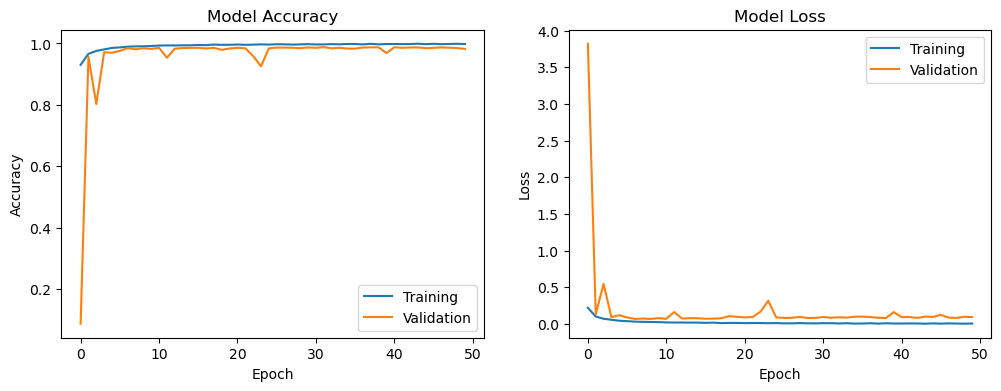

In [13]:
def evaluate_model(model, X_test, y_test, history):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: {:.2f}%".format(scores[1] * 100))
    print(history.history.keys())
    # Plot Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['f1_score'], label='Training')
    ax1.plot(history.history['val_f1_score'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()

evaluate_model(model_conv1d_mit, x_test_mit, y_test_mit, history_conv1d_mit)

### Confusion Matrix

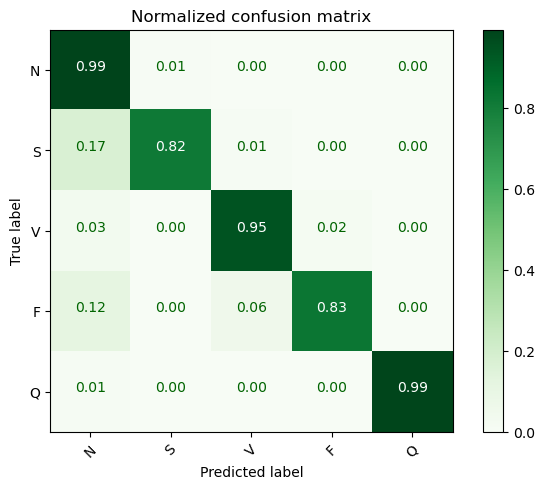

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "darkgreen"
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


cm = confusion_matrix(out_test_mit, conv1d_pred_mit)
plot_confusion_matrix(cm, classes=[MIT_Outcome[i] for i in MIT_Outcome], normalize=True,
                        title='Normalized confusion matrix')